# Рекомендация тарифов

<b>Описание проекта</b>  

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».  

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится.  

Требуется построить модель с максимально большим значением accuracy. Для проекта надо довести долю правильных ответов по крайней мере до 0.75, а также проверить accuracy на тестовой выборке.  

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.   

Известно:

    сalls — количество звонков,
    minutes — суммарная длительность звонков в минутах,
    messages — количество sms-сообщений,
    mb_used — израсходованный интернет-трафик в Мб,
    is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Откройте и изучите файл

In [33]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [34]:
# Читаем данные из csv-файла в датафрейм и сохраним в переменную dataии
data = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

In [35]:
# Функция для отображения общей информации 
def review(data): 
    info = display(data.head()), data.info(), display(data.describe().round(2))    

In [36]:
# Изучим общую информацию о полученном датафрейме
review(data)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
count,3214.00,3214.00,3214.00,3214.00,3214.00
mean,63.04,438.21,38.28,17207.67,0.31
std,33.24,234.57,36.15,7570.97,0.46
min,0.00,0.00,0.00,0.00,0.00
25%,40.00,274.58,9.00,12491.90,0.00
50%,62.00,430.60,30.00,16943.24,0.00
75%,82.00,571.93,57.00,21424.70,1.00
max,244.00,1632.06,224.00,49745.73,1.00


В таблице 5 столбцов и 3214 строк. Все данные выглядят корректно.

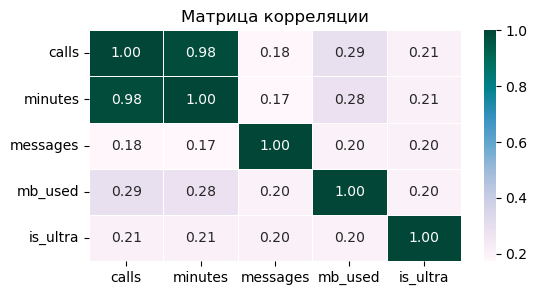

In [73]:
# Проверим корреляцию признаков
# Визуализируем матрицу корреляции с помощью тепловой карты
plt.figure(figsize=(6, 3))
sns.heatmap(data.corr(), annot=True, cmap='PuBuGn', fmt='.2f', linewidths=0.5)
plt.title('Матрица корреляции')
plt.show()

In [38]:
# Проверим оценку VIF
col_list = []
for col in data.columns:
    if ((data[col].dtype != 'object') & (col != 'charges')):
        col_list.append(col)

X = data[col_list]
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 
print(vif_data.round(2))

    feature     VIF
0     calls  129.36
1   minutes  126.50
2  messages    2.24
3   mb_used    4.47
4  is_ultra    1.58


Посчитали корреляции и пришли к выводу, что столбцы с минутами и звонками сильно коррелируют. 

In [39]:
# Получим количество каждого значения для столбца 'is_ultra' в %
data['is_ultra'].value_counts(normalize=True)*100

0    69.352831
1    30.647169
Name: is_ultra, dtype: float64

Пользователи чаще выбирают тариф «Смарт». Пользователей на тарифе «Смарт» около 70%, пользователей на тарифе «Ультра» чуть больше 30%.

Разобьем данные столбца 'is_ultra' на признаки и целевой признак, сохраним в отдельных переменных.

In [40]:
# Запишем признаки в переменную features
features = data.drop(['is_ultra'], axis=1)
# Целевой признак запишем в переменную target
target = data['is_ultra']
# Выведем на экран размеры этих переменных
features.shape, target.shape

((3214, 4), (3214,))

## Разобьем данные на выборки

Спрятанной тестовой выборки нет. Данные нужно разбить на три части: обучающую, валидационную и тестовую. Для этого исходные данные разбивают в соотношении 3:1:1. Размеры тестового и валидационного наборов обычно равны. Разобьем наши данные на 3 выборки: тренировочную - 60%, тестовую - 20% и валидационную - 20%.

In [41]:
# Разобьем данные на тренировочную и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split\
(features, target, train_size=0.6, random_state=12345, stratify=target)   

In [42]:
# Отделим 20% данных для валидационной выборки
features_test, features_valid, target_test, target_valid = train_test_split\
(features_test, target_test, test_size=0.5, random_state=12345, stratify=target_test)

In [43]:
# Выведем на экран размеры этих выборок
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)
print(features_valid.shape)
print(target_valid.shape)

(1928, 4)
(1928,)
(643, 4)
(643,)
(643, 4)
(643,)


## Исследуем модели

Исследуем качество разных моделей, подбирая гиперпараметры, и выберем лучшую модель.

### Дерево решений

В решающем дереве важными гиперпараметрами являются 'max_depth' или выбор критерия — 'gini' либо 'entropy'. Настроим гиперпараметры нашего дерева решений, для этого в цикле нужно перебрать разные значения и сравнить качество моделей в разных вариантах. 

In [44]:
best_model_dt = None
best_result_dt = 0
best_depth_dt = 0
best_criterion = 0
best_splitter =  0

for depth in tqdm(range(1, 151)):    
    for criterion in ['gini', 'entropy']:
        for splitter in ['best', 'random']:
            model = DecisionTreeClassifier(
            random_state=12345,
            criterion=criterion,
            max_depth=depth,
            splitter=splitter   
            )
            model.fit(features_train, target_train)
            predictions_valid = model.predict(features_valid)
            result = accuracy_score(target_valid, predictions_valid)
            if result > best_result_dt:
                best_model_dt = model 
                best_result_dt = result 
                best_depth_dt = depth
                best_criterion = criterion
                best_splitter = splitter
print("Accuracy наилучшей модели на валидационной выборке:", round((best_result_dt),3),
      ',','с лучшим значением criterion =', best_criterion,
      ', лучшим значением max_depth =', best_depth_dt,
      'и лучшим значением best_splitter =', best_splitter
     )   
            


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 49.62it/s]

Accuracy наилучшей модели на валидационной выборке: 0.812 , с лучшим значением criterion = gini , лучшим значением max_depth = 5 и лучшим значением best_splitter = best


### Случайный лес

Попробуем друго алгоритм классификации — случайный лес. В алгоритме случайный лес подберём лучшие значения 'max_depth' и 'n_estimators'. Настроим гиперпараметры с помощью в цикла.


In [45]:
best_model_rf = None
best_result_rf = 0
best_depth_rf = 0
best_est = 0

for est in tqdm(range(1, 101)):
        for depth in range(1, 21):
            model = RandomForestClassifier(
            random_state=12345,
            n_estimators=est,
            max_depth=depth
            )
            model.fit(features_train, target_train)
            predictions_valid = model.predict(features_valid)
            result = accuracy_score(target_valid, predictions_valid)
            if result > best_result_rf:
                best_model_rf = model 
                best_result_rf = result 
                best_depth_rf = depth
                best_est = est    
print("Accuracy наилучшей модели на валидационной выборке:", round((best_result_rf),3),
      ',','с лучшим значением n_estimators =', best_est,
      ' и лучшим значением max_depth =', best_depth_rf
      )   

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:18<00:00,  2.59s/it]

Accuracy наилучшей модели на валидационной выборке: 0.824 , с лучшим значением n_estimators = 31  и лучшим значением max_depth = 12


### Логистическая регрессия

Попробуем ещё один алгоритм — логистическую регрессию. С помощью цикла в алгоритме логистическая регрессия подберём лучшее значение 'max_iter'.

In [46]:
best_model_lr = None
best_result_lr = 0
best_iter = 0

for ex in tqdm(range(100, 301)):
    model = LogisticRegression(
    random_state=12345,
    solver='lbfgs',
    max_iter=ex
    )
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
    if result > best_result_lr:
        best_model_lr = model 
        best_result_lr = result 
        best_iter = ex
print("Accuracy наилучшей модели на валидационной выборке:", round((best_result_lr),3),
      ',','с лучшим значением max_iter =', best_iter)   

100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [00:06<00:00, 33.35it/s]

Accuracy наилучшей модели на валидационной выборке: 0.747 , с лучшим значением max_iter = 100


Наилучший результат Accuracy у случаного леса, но при этом он самый долгий. Остановимся на нем, так как в данном случае считаем, что его время работы не критично. Случайный лес помогает улучшить результат предсказания и избежать переобучения.

## Проверим модель на тестовой выборке

Проверим выбранную модель на тестовой выборке.

In [75]:
test_predictions = best_model_rf.predict(features_test)

print("Accuracy на тестовой выборке:", round(accuracy_score(target_test, test_predictions),3))

Accuracy на тестовой выборке: 0.798


На тестовой выборке доля правильных ответов больше, чем на обучающей выборке. 

## (бонус) Проверим модель на адекватность

Для проверки модели на адекватность используем модель DummyClassifier. Она представляет собой простейшую (dummy) модель, которая всегда предсказывает наиболее часто встречающийся класс. Так мы получим контрольные данные для сравнительной оценки построенной нами более сложной модели.

In [23]:
model = DummyClassifier(strategy='most_frequent', random_state=12345)
model.fit(features_train, target_train)
result = model.score(features_valid, target_valid)
print('Accuracy DummyClassifier:', round((result),3))

Accuracy DummyClassifier: 0.694


Accuracy модели DummyClassifier ниже, чем у модели RandomForestClassifier. Наша модель адекватна и эффективна.

## Общий вывод

Все данные выглядят корректно. Оставили без изменений.  
Спрятанной тестовой выборки нет. Данные разбили на три части: обучающую, валидационную и тестовую в пропорции 60:20:20.  
Были исследованы модели Decision Tree Classifier, RandomForestClassifier и Logistic Regression. Наилучший результат Accuracy - 0.81 - показала модель RandomForestClassifier с гиперпараметрами n_estimators равным - 34 и max_depth равным 10.  
Модель RandomForestClassifier с наилучшими гиперапараметрами была проверена на тестовой выборке и показала результат Accuracy - 0.89.  
Модель RandomForestClassifier была проверена на вменяемость. Для проверки использовалась модель DummyClassifier, которая показала результат Accuracy - 0.68. Наша модель RandomForestClassifier адекватна и эффективна.